# Extending codes to support Vector Autoregressive models

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import xarray as xr

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

from src import ar_model

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [92]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [5]:
DATA_DIR = "../../data/processed"

# Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [8]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = (
    utils.calculate_period_AMV_index(
        HadISST["sst"],
        [12, 1, 2, 3],
    )
    .rename("AMV")
    .compute()
)
AMV = utils.round_to_start_of_month(AMV, dim="time")

HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = (
    utils.calculate_period_NAO_index(
        HadSLP["slp"],
        [12, 1, 2, 3],
    )
    .rename("NAO")
    .compute()
)

AMV, NAO = xr.align(AMV, NAO)

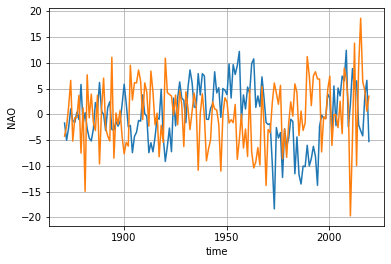

In [9]:
(40 * AMV).plot(label="AMV")
NAO.plot(label="NAO")
plt.grid()

# Fit a VAR model

In [10]:
input_data = pd.concat(
    (AMV.to_dataframe(), NAO.to_dataframe()),
    axis=1,
)

## Check that input series are stationary

In [11]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


## As a check, do the fit myself and compare to `statsmodels`

In [12]:
order = 2

In [13]:
def my_OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)

    b = np.matmul(XtX_Inv, XtY)

    return b

In [14]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1, :]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    my_OLS_fit(predictor, response),
    index=["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"],
    columns=["AMV", "NAO"],
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [15]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the variance of the residuals

In [16]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:, 0], lags=2, trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069776
Standard deviation of residuals: 0.10972513235786074


## Check that generate_samples matches `statsmodels.tsa.vector_ar.var_model.VARProcess`
Note, `generate_samples` below was run with `simulate_var(..., seed=0)` hardcoded internally

In [17]:
AMV_input = AMV.to_dataset()
NAO_input = NAO.to_dataset()

VAR_input = xr.merge((AMV_input, NAO_input))

In [18]:
order = 2
n_times = 50

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


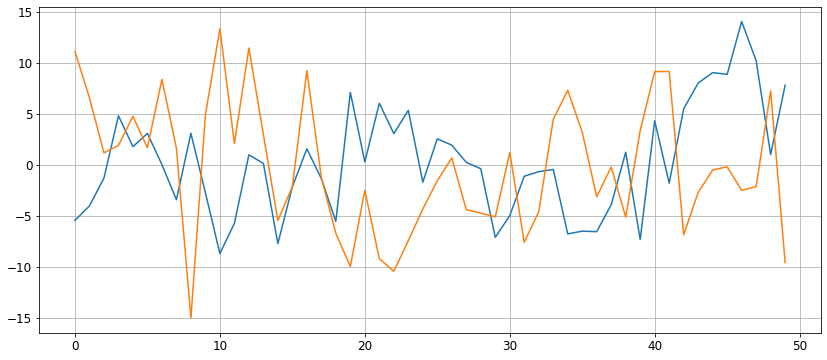

In [19]:
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(40 * a[:, 0])
plt.plot(a[:, 1])
plt.grid()

In [19]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

b = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=1)

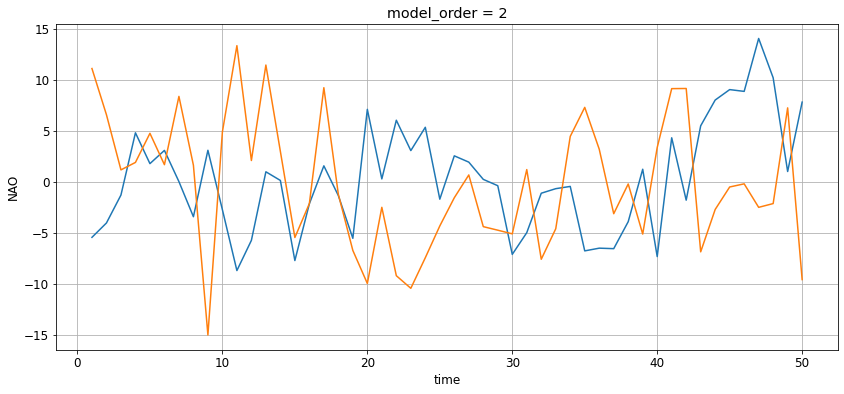

In [24]:
(40 * b["AMV"]).plot()
b["NAO"].plot()
plt.grid()

## Check that predictions match `statsmodels` method

#### VAR model

In [271]:
order = 4
n_steps = 10

In [272]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

# Supress the noise terms
VAR_params = xr.concat(
    (
        VAR_params.isel(params=slice(-2)),
        1e-8 * VAR_params.isel(params=slice(-2, None)),
    ),
    dim="params",
)

In [273]:
my_forecasts = ar_model.predict(VAR_params, inits, n_steps=n_steps).squeeze()

res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

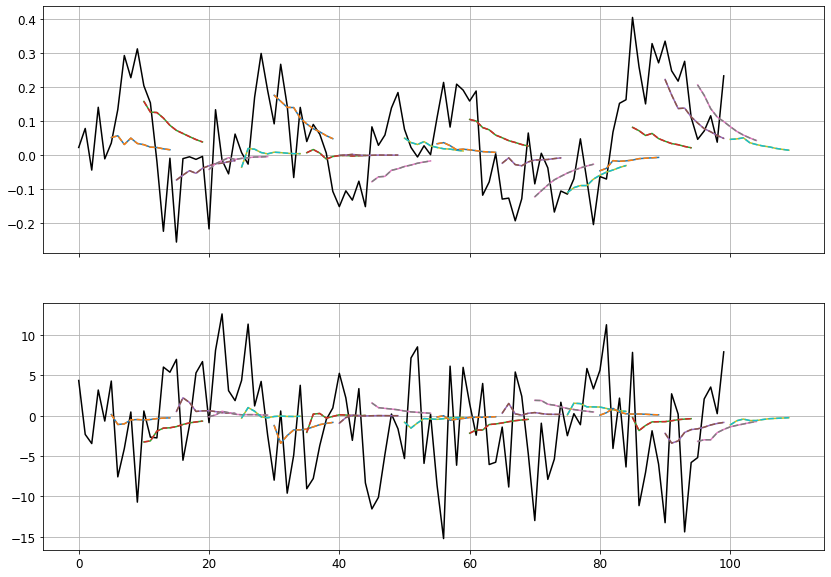

In [274]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"], color="k")
axs[1].plot(inits["NAO"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    axs[0].plot(lead, my_forecast["AMV"])
    axs[1].plot(lead, my_forecast["NAO"])

    their_forecast = res.forecast(
        inits.to_stacked_array(new_dim="var", sample_dims=["time"]).values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

#### AR model

In [228]:
order = 2
n_steps = 10

In [242]:
AR_params = ar_model.fit(AMV_input, n_lags=order)

inits = ar_model.generate_samples(AR_params, n_times=100, n_samples=1)

# Refit to inits so that can use AutoReg predict function
AR_params = ar_model.fit(inits, n_lags=order)

# Supress the noise terms
AR_params = xr.concat(
    (
        AR_params.isel(params=slice(-1)),
        1e-8 * AR_params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

In [243]:
my_forecasts = ar_model.predict(AR_params, inits, n_steps=n_steps).squeeze()

res = AutoReg(inits["AMV"].values, lags=order, trend="n").fit()

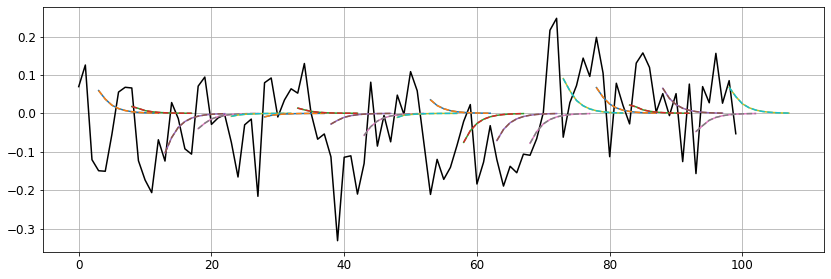

In [244]:
fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits["AMV"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    ax.plot(lead, my_forecast["AMV"])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()

## Test functions when there are multiple params

#### Fit AMV and NAO AR params at the same time and compare to statsmodels

In [275]:
input_data = (
    xr.concat((AMV, NAO), dim="variable")
    .assign_coords({"variable": ["AMV", "NAO"]})
    .to_dataset(name="dummy")
)

AR_params = ar_model.fit(input_data, n_lags="select_order", kwargs={"maxlag": 10})

In [276]:
print(f"My AMV coefs: {AR_params['dummy'].sel(variable='AMV')[:-1].values}")
print(f"My AMV sigma2: {AR_params['dummy'].sel(variable='AMV')[-1:].values}")

ar_lags = ar_select_order(AMV.values, maxlag=10, trend="n").ar_lags
n_lags = len(ar_lags) if ar_lags is not None else 0
res = AutoReg(AMV.values, lags=n_lags, trend="n").fit()

print(f"sm AMV coefs: {res.params}")
print(f"sm AMV sigma2: {res.sigma2}")

My AMV coefs: [0.44292607 0.25604035]
My AMV sigma2: [0.01203969]
sm AMV coefs: [0.44292607 0.25604035]
sm AMV sigma2: 0.012039687318878676


In [277]:
print(f"My NAO coefs: {AR_params['dummy'].sel(variable='NAO')[:-1].values}")
print(f"My NAO sigma2: {AR_params['dummy'].sel(variable='NAO')[-1:].values}")

ar_lags = ar_select_order(NAO.values, maxlag=10, trend="n").ar_lags
n_lags = len(ar_lags) if ar_lags is not None else 0
res = AutoReg(NAO.values, lags=n_lags, trend="n").fit()

print(f"sm NAO coefs: {res.params}")
print(f"sm NAO sigma2: {res.sigma2}")

My NAO coefs: [nan nan]
My NAO sigma2: [36.64092375]
sm NAO coefs: []
sm NAO sigma2: 36.64092374981912


#### Fit a VAR model to the same data multiple times

In [278]:
input_data = xr.concat([VAR_input] * 3, dim="dim1")
input_data = xr.concat([input_data] * 5, dim="dim2")

In [279]:
VAR_params = ar_model.fit(input_data, n_lags=order)
my_VAR_params = VAR_params.isel(dim1=0, dim2=0)

In [280]:
res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

print(f"My AMV coefs: {my_VAR_params['AMV'][:-2].values}")
print(f"My AMV sigma2: {my_VAR_params['AMV'][-2:].values}")
print(f"sm AMV coefs: {res.params[:,0]}")
print(f"sm AMV sigma2: {res.sigma_u[:,0]}\n")

print(f"My NAO coefs: {my_VAR_params['NAO'][:-2].values}")
print(f"My NAO sigma2: {my_VAR_params['NAO'][-2:].values}")
print(f"sm NAO coefs: {res.params[:,1]}")
print(f"sm NAO sigma2: {res.sigma_u[:,1]}")

My AMV coefs: [ 0.41048943 -0.00073131  0.21335734  0.00090178  0.02298906  0.00107604
  0.1364497   0.00140639]
My AMV sigma2: [ 0.01247832 -0.10018053]
sm AMV coefs: [ 0.41048943 -0.00073131  0.21335734  0.00090178  0.02298906  0.00107604
  0.1364497   0.00140639]
sm AMV sigma2: [ 0.01247832 -0.10018053]

My NAO coefs: [-1.11757653e+00  5.60197426e-02 -8.52180673e+00 -6.51470983e-03
 -3.18821012e+00  2.26840274e-02  1.52441897e+00 -7.88182621e-04]
My NAO sigma2: [-0.10018053 36.47952287]
sm NAO coefs: [-1.11757653e+00  5.60197426e-02 -8.52180673e+00 -6.51470983e-03
 -3.18821012e+00  2.26840274e-02  1.52441897e+00 -7.88182621e-04]
sm NAO sigma2: [-0.10018053 36.47952287]


In [281]:
print(
    f"VAR params are the same across all dimensions: {(VAR_params - my_VAR_params == 0).all().to_array().values}"
)

VAR params are the same across all dimensions: [ True  True]


#### Test that `generate_samples` can handle multiple sets of params

In [282]:
# This is hard to test because of the randomisation, but just check it runs
_ = ar_model.generate_samples(AR_params, n_times=10, n_samples=2)

In [283]:
# This was run with `simulate_var(..., seed=0)` hardcoded internally
samples = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=2)

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


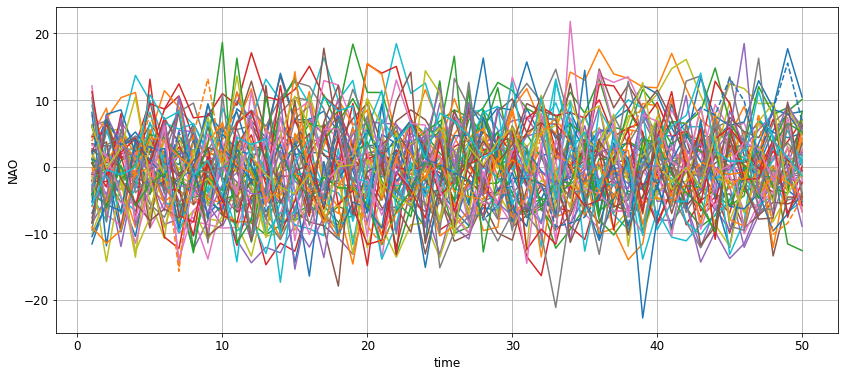

In [284]:
_ = (
    (40 * samples["AMV"])
    .stack(dummy=["dim1", "dim2", "sample"])
    .plot.line(x="time", add_legend=False)
)
_ = (
    samples["NAO"]
    .stack(dummy=["dim1", "dim2", "sample"])
    .plot.line(x="time", add_legend=False)
)

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(samples["AMV"].time, 40 * a[:, 0], linestyle="--")
plt.plot(samples["NAO"].time, a[:, 1], linestyle="--")
plt.grid()

#### Test that predictions match `statsmodels` when there are multiple params

In [336]:
order = 4
n_steps = 10

In [342]:
input_data = VAR_input  # xr.concat([VAR_input] * 3, dim="dim1")
# input_da ta = xr.concat([input_data] * 5, dim="dim2")

In [343]:
VAR_params = ar_model.fit(input_data, n_lags=order)

In [364]:
inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

# Reduce the noise component
# VAR_params = xr.concat(
#     (
#         VAR_params.isel(params=slice(-2)),
#         VAR_params.isel(params=slice(-2, None)),
#     ),
#     dim="params",
# )

In [365]:
my_forecasts = ar_model.predict(
    VAR_params, inits, n_steps=n_steps, n_members=10
).squeeze()

res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]
[0. 0.]
[[ 1.24783229e-02 -1.00180529e-01]
 [-1.00180529e-01  3.64795229e+01]]


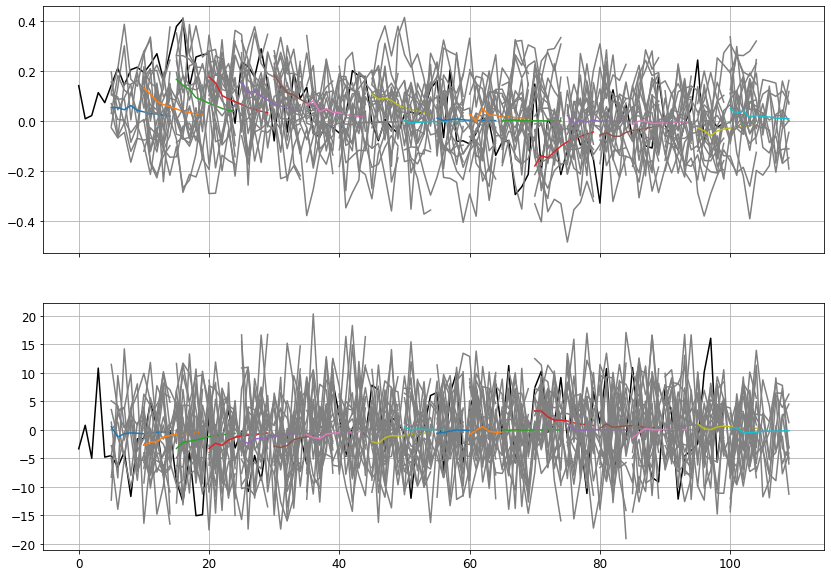

In [366]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"], color="k")
axs[1].plot(inits["NAO"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    for member in my_forecast.member:
        axs[0].plot(lead, my_forecast["AMV"].sel(member=member), color="grey")
        axs[1].plot(lead, my_forecast["NAO"].sel(member=member), color="grey")

    their_forecast = res.forecast(
        inits.to_stacked_array(new_dim="var", sample_dims=["time"]).values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0])
    axs[1].plot(lead, their_forecast[:, 1])

axs[0].grid()
axs[1].grid()

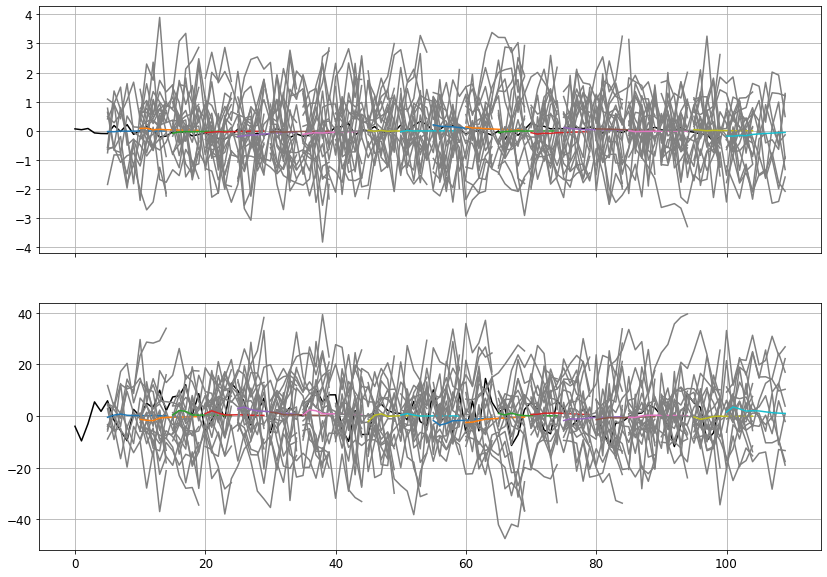

In [341]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"].isel(dim1=0, dim2=0), color="k")
axs[1].plot(inits["NAO"].isel(dim1=0, dim2=0), color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.isel(dim1=0, dim2=0).sel(init=init)

    lead = my_forecast.lead + init
    for member in my_forecast.member:
        axs[0].plot(lead, my_forecast["AMV"].sel(member=member), color="grey")
        axs[1].plot(lead, my_forecast["NAO"].sel(member=member), color="grey")

    their_forecast = res.forecast(
        inits.isel(dim1=0, dim2=0)
        .to_stacked_array(new_dim="var", sample_dims=["time"])
        .values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0])
    axs[1].plot(lead, their_forecast[:, 1])

axs[0].grid()
axs[1].grid()

## Test `generate_samples_like` function, including diagnostic plots

In [34]:
test = ar_model.generate_samples_like(
    VAR_input,
    n_lags=2,
    n_times=45,
    n_samples=3,
    n_members=20,
    rolling_means=[8],
    plot_diagnostics=True,
)

ValueError: One or more of the specified variables cannot be found in this dataset